# Signal Analysis using DFT

__Desired Learning Outcomes__:
* Understanding the relation between DFT index and wave frequency.
* Interpreting the Magnitude of component sinusoids from a N-point DFT.
* Interpreting the Phase of component sinusoids from a N-point DFT.

__Libraries and notebook-config:__

In [2]:
from numpy import sin, cos, pi, exp, append, mean, absolute, angle # Sentrale matematiske funksjoner
from numpy.fft import fft, ifft             # DFT og IDFT
import numpy as np                          # Importer funksjonalitet fra numpy biblioteket med prefiks "np"
import matplotlib.pyplot as plt             # Importer pyplot modulen i matplotlib med prefiks "plt"
from scipy.io import loadmat

%matplotlib inline

#### Introduction
The focus of this task will be to use the Fast Fourier Transform (FFT) to perform frequency-domain analysis of a sample signal $x[n]$ stored in a data file `lab3.mat`. The signal $x[n]$ has a duration of $N=128$ samples, and consists of two sinusoid components added together: $x[n] = A_1\cdot \cos\left(\hat{\omega}_1\cdot n + \phi_1 \right) + A_2\cdot \cos\left(\hat{\omega}_2\cdot n + \phi_2 \right)$. 

The code cell below shows how both the sample values $x[n]$ and the sample numbers $n$ are loaded into suitable arrays.




In [3]:
fileData = loadmat('lab4.mat', squeeze_me=True)

n = fileData['n']
N = len(n)
x_1 = fileData['x1[n]']
print(f'n = {n} \n')
print(f'N = {N} \n')
print(f'x_1 = {x_1} \n')
print(f'len(x_1) = {len(x_1)} \n')


n = [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127.] 

N = 128 

x_1 = [-0.28284271  0.39439759  0.44884764 -0.03099834  0.16045534  0.81448818
  0.74412893  0.27279757  0.55403341  1.14962808  0.94758348  0.49390876
  0.8458434   1.35261094  1.01999214  0.59566654  1.          1.39470291
  0.94157842  0.56126973  1.00191566  1.26993377  0.71535574  0.39639283
  0.86018015  0.995989    0.3670115

#### Analysis of discrete-time signals in Python

As we can see in the above codecell, $x[n]$ is represented purely as a digital, or discrete-time signal. Sampling frequency is not included in the file, and as such the only meaningful unit of time to form the basis of signal analysis is *sample number* $n$, and frequencies need to be measured in *cycles per sample* $\hat{f}$ or *radians per sample* $\hat{\omega}$. 

When working with a digital signal, it is often desirable to use a [stem plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stem.html) to represent the data in a way makes it's discrete nature evident. Below is an example of how the sample signal $x[n]$ from the data file `lab3.mat` can be visualized using a stem plot.

<!--
The primary focus for this course will be digital signals, 
Hoveddelen av dette emnet vil vi arbeide med digitale signal, som er en såkalt tidsdiskrét utgave av et reelt analogt signal. Dette er en serie med målinger for tidspunktene $t = n\cdot T_s, \ \ n \in \mathbb{Z}$ der $T_s$ er samplingsfrekvensen. Forholdet mellom et digitalt signal $x[n]$ og et analogt signal $x(t)$ er altså:
$$ x[n] = x(n\cdot T_s)$$

Dersom vi ønsker å generere en digital sinus-sekvens $x[n]$ for en sinusbølge med frekvens $f = 100Hz$, og samplingsfrekvens $f_s = 2400Hz$, så blir uttrykket slik vist nedenfor, der den _digitale perioden_ $M$ er 24 sampler, noe som betyr at sinus-sekvensen gjentar seg selv etter 24 sampler.
$$x[n] = \cos\left(2\pi \cdot 100 \cdot n \cdot T_s \right) = \cos \left(2\pi\frac{100}{2400}\cdot n \right) = \cos \left(\frac{\pi}{12}\cdot n \right)$$
De første 96 samplene i et slikt signal kan vi generere med koden nedenfor. For å plotte et slikt signal bruker vi ofte funksjonen [`stem`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stem.html) for å lage et *stolpediagram* der hver stolpe representerer én sample. Dette er ofte hensiktsmessig når vi har relativt små sekvenser å analysere (for signaler med lengde noe særlig mere enn $100$ sampler begynner stolpediagram å være en lite gunstig måte å visualisere signalet på, og et linjeplot vil være å foretrekke).


I denne oppgaven skal vi se på et testsignal $x[n]$ med 128 sampler, bestående av to sinussekvenser som er lagt sammen $x[n] = A_1\cdot \cos\left(\hat{\omega}_1\cdot n + \phi_1 \right) + A_2\cdot \cos\left(\hat{\omega}_2\cdot n + \phi_2 \right)$. Signalet lastes inn fra datafila `lab3.mat`, og er signalet gitt i kolonnen merket `x1[n]`. Ved å regne DFT (fft) av dette signalet kan vi analysere frekvensinnholdet i signalet. Koden nedenfor vil laste inn signalet `x1[n]` fra datafila, regne ut signalets DFT, og visualisere resultatet ved bruk av funksjonen `timeSpectrumStem()` som er laget for denne dataøvingen. Denne funksjonen tar in digitalt signal som tidsserie (`xn1`), signalets DFT (`Xk1`), og antall sampler (`N`) som parametre.-->

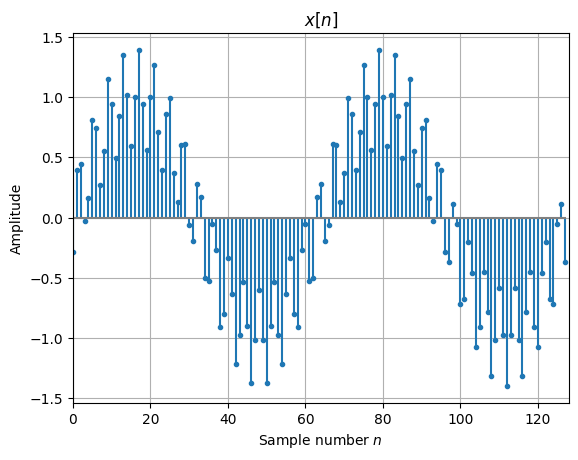

In [4]:
import matplotlib.pyplot as plt 

plt.stem(n, # Sample number
         x_1, # Signal values
         linefmt='-', # Line style for stem lines
         markerfmt='.', # Stem marker style
         basefmt='grey', # Base line style (horizontal line at 0.0)
        )
plt.xlabel("Sample number $n$")
plt.ylabel("Amplitude")
plt.title("$x[n]$")
plt.xlim([0, N])
plt.grid(True)

#### The FFT function

The FFT function in numpy produces an array of complex number values that we mathematically refer to as $X[m]$. This function transforms $N$ samples of a digital signal $x[n]$ into a frequency domain representation. Each element in $X[m]$ contains information about the magnitude $A_m = \left| X[m] \right|$ and phase $\phi_m = \angle X[m]$ of a frequency component that completes $m$ full rotations in $N$ samples. So far, this is almost identical to the Fourier Series we learned about in exercise 2, exept we are observing the signal over a sample interval $N$ rather than a time interval $T$ measured in seconds. 

One significant consequence of the signal being discrete rather than continuous is that there are not infinitely many possible frequency components in a DFT due to the sampling theorem, and as such the Nyquist Frequency component can be found at index $m = \frac{N}{2}$. Beyond index $m = \frac{N}{2}$ we find an *alias* of the negative frequency spectrum, meaning the FFT of a real-valued signal will be complex conjugate symmetric around $m=\frac{N}{2}$. If you would like to know more, the book provides a thorough explanation of how the DFT process works in chapters 3.1 and 3.2.

## a)
Use the numpy-function `fft` to calculate the DFT of $x[n]$, and use the function `abs` to create a **stem plot** of the *magnitude spectrum*  $|X[m]|$:

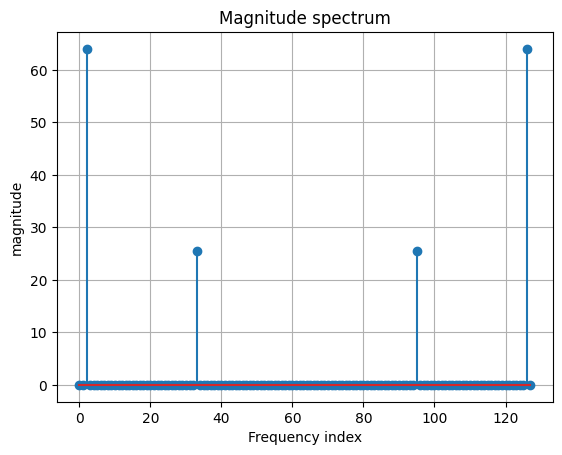

In [5]:
# WRITE YOUR CODE IN THIS CELL:
from scipy.fft import fft, fftfreq, fftshift


###############################
#https://www.geeksforgeeks.org/matplotlib-pyplot-stem-in-python/
# https://docs.scipy.org/doc/scipy/tutorial/fft.html

##  frequencies need to be measured in *cycles per sample*
#Nyquist Frequency component can be found at index $m = \frac{N}{2}$
#Dersom vi ønsker å generere en digital sinus-sekvens $x[n]$ for en sinusbølge med frekvens $f = 100Hz$, og samplingsfrekvens $f_s = 2400Hz$, så blir uttrykket slik vist nedenfor, der den _digitale perioden_ $M$ er 24 sampler, noe som betyr at sinus-sekvensen gjentar seg selv etter 24 sampler.


#24 samples per cycle
T = 1/24 # samples spacing
xAxis=fftfreq(N,T)





XMagnitude = abs(fft(x_1))
#freqAxis = np.linspace(n[0], n[-1], 24)

plt.stem(XMagnitude)
plt.xlabel('Frequency index')
plt.ylabel('magnitude')
plt.title('Magnitude spectrum')
plt.grid(True)
plt.show()


*PS: The stem magnitude figue of $X[M]$ should look something like [this.](Figures/task1a_sol.png)*

## b) 
Calculate the phase spectrum $\phi[m] = \angle X[m]$ using the numpy-function `angle`. <br>
*Beware, there are always rounding errors when working with floating-point numbers (which the FFT does), and the elements of $X[m]$ which *should* equal zero will be very small numbers (e.g. `5.124e-16`). The `angle`-function will calculate the angle for all these numbers as well. To avoid the phase spectrum looking like white noise, use `np.where`.*<br>
*Example:*
```python
phase = np.where(magnitude > 1e-8, np.angle(Xm), 0)
```

Create a stem plot showing the phase spectrum $\angle X[m]$. Bonus points if the y axis units are fractions of $\pi$.

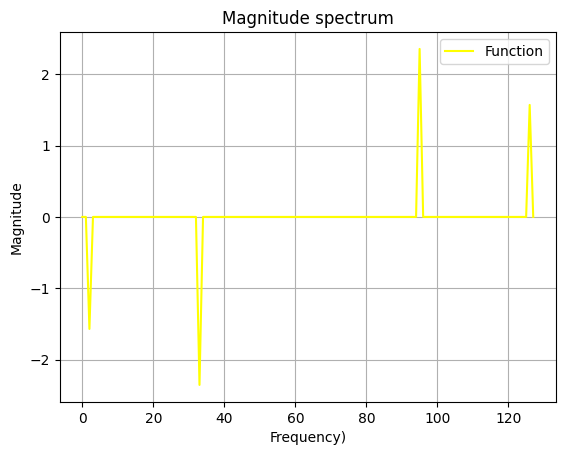

In [20]:
# WRITE YOUR CODE IN THIS CELL:
#https://stackoverflow.com/questions/56543190/phase-spectrum-with-python-and-fft
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import numpy as np
fft = fft(x_1)
xMagnitude = abs(fft)
phase = np.angle(fft)

plt.plot(np.where(xMagnitude>1e-8, phase, 0), color='yellow', label='Function')
#ax3.magnitude_spectrum(xtSin, Fs=fs, color='red', label='x(t) * sin(2 * np.pi * t)')

plt.xlabel("Frequency)")
plt.ylabel("Magnitude")
plt.title("Magnitude spectrum")
plt.grid(True)
plt.legend()



*PS: The stem phase figue of $X[m]$ should look something like [this.](Figures/task1b_sol.png)*



As we see in the plots from **a)** and **b)**, there are four elements in the calculated DFT sequence $X[m]$ where the frequency components of $x[n]$ are represented. The indices of these elements can be identified by identifying the nonzero  elements and taking note of their position (approximating very small numbers to zero).
<!--Study the plots from **a)** and **b)**. For which index values $m$ do we find the elements in the $DFT$ sequence $X[m]$ which correspond with the two sinusoids with frequency $\hat{\omega}_1$ and $\hat{\omega}_2$?
Studer figurene. For hvilke indeksverdier $k$ finner vi elementene i DFT-sekvensen $X[k]$ som hører til de to sinuskomponentene med frekvens $\hat{\omega}_1$ og $\hat{\omega}_2$? -->

In [7]:
indices = []
for m, X in enumerate(XMagnitude):
    if np.abs(X) > 1e-6:
        indices.append(m)
print(indices)

[2, 33, 95, 126]


*PS. The above can also be achieved with a simple one-liner.* `indices = np.flatnonzero(np.abs(Xm)> 1e-6)`

## c)

Together, the four component nonzero elements represent two sinusoidal components with normalized angular frequencies $w_1$ and $w_2$. Based on their index values, identify the normalized angular frequencies $w_1$ and $w_2$ and provide the answers in radians per sample

_Hint: just as the series index $k$ in a fourier series denotes **number of cycles in the space of one fundamental period $T$**, the DFT index $m$ denotes **number of cycles in the space of $N$ samples**._
<!--
Determine the normalized angular frequencies $\hat{\omega}$ which corresponds to each of the element indices. Also, determine which of the elements are part of the same sinusoid.-->

In [8]:
# Replace the strings "???" below with answers as a numerical value

#for normalizing them we divide by N


w_1 = 2 * np.pi * indices[0] / N  # Lowest frequency component
w_2 = 2 * np.pi * indices[1] / N  # Highest frequency component
# WRITE YOUR CODE IN THIS CELL:

In [9]:
from hashlib import sha1
assert sha1(str(round(float(w_1), 5)).encode('utf-8')+b'78f94').hexdigest() == '5e33eec4df4694b7114d486651a68c3c46f0ea42', 'Wrong answer for "w_1" :('
print('Correct answer for "w_1" :)')
assert sha1(str(round(float(w_2), 5)).encode('utf-8')+b'78f94').hexdigest() == '0f0eb067818e8060ac4d59e4d1166e9fa6a2dd44', 'Wrong answer for w_2:('
print('Correct answer for "w_2" :)')

Correct answer for "w_1" :)
Correct answer for "w_2" :)


## d)
Formulate an explanation for the "remaining" indices not "used" in question **c)**.

ANSWER THEORY QUESTIONS HERE:

The complex numerical values for the nonzero elements in $X[m]$ can be extracted using the array `indices`, as seen in the code cell below:

In [10]:
#print(f'XMagnitude = {XMagnitude}')
#print(f'fft = {fft}')



for m, X_val in zip(indices, fft[indices]):
    print(f"{m = }, X[m] = {X_val}")

m = 2, X[m] = (-1.905176354236926e-14-64j)
m = 33, X[m] = (-18.10193359837556-18.101933598375677j)
m = 95, X[m] = (-18.10193359837556+18.101933598375677j)
m = 126, X[m] = (-1.905176354236926e-14+64j)


## e)
Use the complex values in the nonzero elements of $X[m]$ to calculate a corresponding magnitude component for the two sinusoids in the signal $x[n]$. 
<!--
We can print the numerical values for selected elements in $X_1[m]$ by means of indexing, and use the `np.abs` and `np.angle` functions to convert the complex numbers to magnitude and angle. Example:
```python
m = 81
print(f"X[{k}] has magnitude {np.abs(X[m]):.1f} and angle {np.angle(X[m]):.2f} Pi")
```
- Print the elements in `X[m]` which represent the two separate sinusoids in the signal $x[n]$. Find magnitude $A$, phase $\phi$ and normalized angular frequency $\hat{\omega}$.
- If the sampling frequency for the signal is $f_s = 4096\text{ Hz}$, what is the frequenc of the two sinusoids $f_1$ and $f_2$ in $\text{Hz}$?-->

<!--Vi kan skrive ut numeriske verdier til utvalgte element i $X_1[k]$, og ett "par" med symmetrisk plasserte element representerer én sinusbølge. Ett eksempel på hvordan man kan finne verdien til eksempelvis $X_1[81]$ i polarkoordinater er vist nedenfor:
```python
k = 81
print("X[%d] har absoluttverdi %.1f og vinkel %.2f Pi"% (k, absolute(Xk1[k]), angle(Xk1[k])/pi))
```
- Studer de ulike sinuskomponentene til $x_1[n]$ i frekvensplanet ved å skrive ut verdien(e) til alle DFT-elementene som tilhører de to sinusbølgene som utgjør signalet. Finn så amplitude $A$, normalisert vinkelfrekvens $\hat{\omega}$ og fase $\phi$ for hver sinuskomponent.
- Hvis signalet har en samplingsfrekvens $f_s = 4096Hz$, hva er frekvensen til de to sinuskomponentene $f_1$ og $f_2$ i Hz?-->

In [11]:
# Replace the strings "???" below with answers as a numerical value
import numpy as np
print(indices)

print(f'Magnitude indices = {np.abs(fft[indices])}')

 
#Slide: Relasjon mellom |X|m|| og amplitude på sinuskomponent


A_1 =  (np.abs(fft[indices[0]]) + np.abs(fft[indices[0]])) / N # abs(-1.905176354236926e-14-64j)  # Lowest frequency component
A_2 = (np.abs(fft[indices[1]]) + np.abs(fft[indices[2]])) / N  # Highest frequency component
# WRITE YOUR CODE IN THIS CELL:
# Print the magnitudes for checking
print(f"A_1 = {A_1}")
print(f"A_2 = {A_2}")


[2, 33, 95, 126]
Magnitude indices = [64.  25.6 25.6 64. ]
A_1 = 1.0
A_2 = 0.4


In [12]:
from hashlib import sha1
assert sha1(str(round(float(A_1), 2)).encode('utf-8')+b'e0b5a').hexdigest() == 'bdcdf5e13c4755bd7b589b4ad5ed8199aca7d4bc', 'Wrong answer for A_1 :('
print('Correct answer for A_1 :)')
assert sha1(str(round(float(A_2), 2)).encode('utf-8')+b'e0b5a').hexdigest() == '52349966e709e8539efa2a5be7bf302d1b9d1fef', 'Wrong answer for A_2 :('
print('Correct answer for A_2 :)')

Correct answer for A_1 :)
Correct answer for A_2 :)


## f)
Use the complex values in the nonzero elements of $X[m]$ to calculate a corresponding phase component for the two sinusoids in the signal $x[n]$. Provide the answer in radians.


In [13]:
# Replace the strings "???" below with answers as a numerical value
phi_1 = np.angle(fft[indices[0]])  # Lowest frequency component
phi_2 = np.angle(fft[indices[1]])  # Highest frequency component
print(f'{phi_1 = }')
print(f'{phi_2 = }')
# WRITE YOUR CODE IN THIS CELL:

phi_1 = -1.570796326794897
phi_2 = -2.3561944901923417


In [14]:
from hashlib import sha1
assert sha1(str(round(float(phi_1), 2)).encode('utf-8')+b'652c3').hexdigest() == 'df90f31ac958dbd115ac2777b5df0f6f26ac4211', 'Wrong answer for phi_1 :('
print('Correct answer for phi_1 :)')
assert sha1(str(round(float(phi_2), 2)).encode('utf-8')+b'652c3').hexdigest() == '062056d69fc83c05569353f2fce79f986d5bb0d1', 'Wrong answer for phi_2 :('
print('Correct answer for phi_2 :)')

Correct answer for phi_1 :)
Correct answer for phi_2 :)


## g)
If the signal has a sampling frequency $f_s = 4096Hz$, what is the wave frequency of the two sinusoids $f_1$ and $f_2$ in Hz?

In [15]:
# Replace the strings "???" below with answers as a numerical value
from math import pi
import numpy as np

# https://home.engineering.iastate.edu/~julied/classes/ee524/LectureNotes/l5.pdf
#  For a sampled signal Tp = N/fs where N is the number of samples in one period of the signal and fs is the sampling frequency.

fs = 4096

N = len(fft)

f_1 =  indices[0] * fs  / N   # Lowest frequency component
f_2 = indices[1] * fs / N  # Highest frequency component
# WRITE YOUR CODE IN THIS CELL:

In [16]:
from hashlib import sha1
assert sha1(str(round(float(f_1), 2)).encode('utf-8')+b'2b2b9').hexdigest() == '7014ec855b6155618b9cce927839352e38f1889d', 'Wrong answer for f_1 :('
print('Correct answer for f_1 :)')
assert sha1(str(round(float(f_2), 2)).encode('utf-8')+b'2b2b9').hexdigest() == '42663e5e49ce7f8cb0e4c7ec31f8c0454769bddd', 'Wrong answer for f_2 :('
print('Correct answer for f_2 :)')

Correct answer for f_1 :)
Correct answer for f_2 :)


## h) 
If the signal has a sampling frequency $f_s = 4096 \text{Hz}$, what is the *resolution bandwidth* of the DFT sequence $X[m]$ in Hertz (Hz)?

*PS. The resolution bandwidth is a measure of how detailed the resolution of the signal's frequency content is in the frequency domain. Sometimes referred to as DFT bin width, it corresponds to the spacing in $Hz$ between two neighboring elements in $X[m]$*

In [17]:
# Replace the string "???" below with answers as a numerical value


# Source : https://home.engineering.iastate.edu/~julied/classes/ee524/LectureNotes/l5.pdf
#Source says 
#f_fes = 1/(N*T) where 1/T is equal to fs 


#Frequency resolution is determined only by the length of the observation interval, whereas the frequency interval is determined by the length of sampling interval. Thus

# Increase sampling rate =⇒ expand frequency interval,

# Increase observation time =⇒ improve frequency resolution.



fs = 4096

RBW =  fs / N
# WRITE YOUR CODE IN THIS CELL:

In [18]:
from hashlib import sha1
assert sha1(str(round(float(RBW), 2)).encode('utf-8')+b'c530c').hexdigest() == '8adfd91e704e2b76aa8e815f22e4c963e0a84be7', 'Wrong answer for RBW :('
print('Correct answer for RBW :)')

Correct answer for RBW :)
